# Custom Cnn Baseline:

## 1: Imports

In [ ]:
# A bunch of imports we need
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Add, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# For data stuff
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils import class_weight

## 2: GPU Check

In [2]:
# This checks for GPU, copied from the first notebook to make sure everything is working.
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Great! Found the GPU:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPU found!!! The model will run on the CPU, which will be a lot slower. Make sure you have installed TensorFlow and the correct CUDA drivers before proceeding with the next steps!")

Great! Found the GPU:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 3: Load our datasets CSV file

In [3]:
# The path to your data folder, this is mine, change it to yours if you want to run this notebook!
# This should be the only line you need to change.
data_path = r'C:\Users\Leo\Desktop\Group_Pneumonia_Detection\data'

# Paths to the csv files, you don't need to change these
train_csv_path = os.path.join(data_path, 'train.csv')
valid_csv_path = os.path.join(data_path, 'valid.csv')

# Load the csv files
try:
    train_df = pd.read_csv(train_csv_path)
    valid_df = pd.read_csv(valid_csv_path) # We will keep this for the final test
    print("Successfully loaded the CSV files!")

except FileNotFoundError:
    print("Error! Make sure you have change the data_path with your actual path!")

Successfully loaded the CSV files!


## 4: Getting the Data Ready

In [4]:
# We only want to classify 'Pneumonia' vs 'Healthy'.
# So we are gonna ignore the NaN and -1.0 labels for this entire project.
# So we need to filter our dataframe to only keep the rows where Pneumonia is 0.0 or 1.0.
pneumonia_df = train_df[train_df['Pneumonia'].isin([0.0, 1.0])].copy()

# The file paths in the CSV aren't complete, so we need to create the full paths.
def create_full_path(row):
    # This basically joins our main data_path with the real path from the CSV.
    relative_path = os.path.join(*row['Path'].split('/')[1:])
    return os.path.join(data_path, relative_path)

pneumonia_df['FullPath'] = pneumonia_df.apply(create_full_path, axis=1)

# Create a new column 'Label' with string labels for better readability
pneumonia_df['Label'] = pneumonia_df['Pneumonia'].apply(lambda x: "Pneumonia" if x == 1.0 else "Healthy")

## 5: Splitting the Data

In [5]:
# The original 'valid.csv' is very tiny, so we'll save it for a final test at the very end.
# For now, we'll split our main training data into a new training set and a validation set (80/20 split).
train_data, val_data = train_test_split(
    pneumonia_df,
    test_size=0.20,
    # So the split is the same every time we run this
    random_state=42, 
    stratify=pneumonia_df['Label']
)

## 6: Setting up the Data Generators

In [6]:
# Standard image size for CNN
IMG_SIZE = (224, 224)
# Setting for my GPU.
BATCH_SIZE = 32

# Small data augmentation for the training data.
# This should help the model generalize better.
train_datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,   
    fill_mode='nearest'
)

# For the validation data, we only need to normalize it. No augmentation in validation set.
val_datagen = ImageDataGenerator(rescale=1./255)

# These generators will feed the images to the model during training and validation.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='FullPath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='FullPath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 7070 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.


## 7: Building the CNN Model

In [7]:
# To make a deep network train properly, we used a special "conv block" structure.
def conv_block(input_tensor, filters, stride=1):
    # A custom convolutional block.
    # The main path where we do the convolutions
    main_path = Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    main_path = BatchNormalization()(main_path)
    main_path = Activation('relu')(main_path)

    main_path = Conv2D(filters, (3, 3), padding='same')(main_path)
    main_path = BatchNormalization()(main_path)

    # The shortcut path is just the original input to the block
    shortcut_path = input_tensor
    
    # If the main path changed the size of the image or the number of filters,
    # we need to adjust the shortcut so their shapes match for the final addition.
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut_path = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut_path)
        shortcut_path = BatchNormalization()(shortcut_path)

    # We add the shortcut to the main path's output.
    # This helps the model remember important features from the original input.
    output = Add()([main_path, shortcut_path])
    output = Activation('relu')(output)
    return output

# Building the custom CNN model using the conv blocks
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# A standard starting block
x = Conv2D(64, (7, 7), strides=2, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

# Stacking our custom conv blocks to make the model deep
x = conv_block(x, 64)
x = conv_block(x, 64)

x = conv_block(x, 128, stride=2) 
x = conv_block(x, 128)

x = conv_block(x, 256, stride=2)
x = conv_block(x, 256)

# This is prevent overfitting.
x = GlobalAveragePooling2D()(x)

# The final classification part
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 

# The output neuron, Sigmoid is for yes no problems.
output_tensor = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

## 8: Compiling the Model

In [8]:
# Calculate class weights to handle class imbalance
# Our dataset is imbalanced (way more Pneumonia than Healthy).
# Class weights will make the model pay more attention to the 'Healthy' class during training.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"\nClass Weights: {class_weights_dict}")


model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy',         
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)


Class Weights: {0: 1.5788298347476553, 1: 0.7317325605464707}


## 9: Training the Model!

In [9]:
# Training with EarlyStopping and ReduceLROnPlateau
callbacks = [
    # This will stop the training early if it stops improving.
    EarlyStopping(
        monitor='val_auc', 
        mode='max',
        patience=8,        
        verbose=1,
        restore_best_weights=True 
    ),
    # This will lower the learning rate if we get stuck on a plateau.
    ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
220/220 [==============================] - 76s 308ms/step - loss: 0.6920 - accuracy: 0.5823 - auc: 0.6186 - precision: 0.7565 - recall: 0.5726 - val_loss: 0.9184 - val_accuracy: 0.3170 - val_auc: 0.6012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
220/220 [==============================] - 61s 277ms/step - loss: 0.6555 - accuracy: 0.6194 - auc: 0.6651 - precision: 0.7895 - recall: 0.6038 - val_loss: 0.7955 - val_accuracy: 0.3597 - val_auc: 0.6348 - val_precision: 0.8641 - val_recall: 0.0740 - lr: 1.0000e-04
Epoch 3/50
220/220 [==============================] - 56s 256ms/step - loss: 0.6498 - accuracy: 0.6154 - auc: 0.6691 - precision: 0.7879 - recall: 0.5988 - val_loss: 0.6645 - val_accuracy: 0.5830 - val_auc: 0.6818 - val_precision: 0.8071 - val_recall: 0.5116 - lr: 1.0000e-04
Epoch 4/50
220/220 [==============================] - 57s 261ms/step - loss: 0.6440 - accuracy: 0.6306 - auc: 0.6801 - precision: 0.7986 - recall: 0.6143 - val_loss

## 10: Plotting the Results

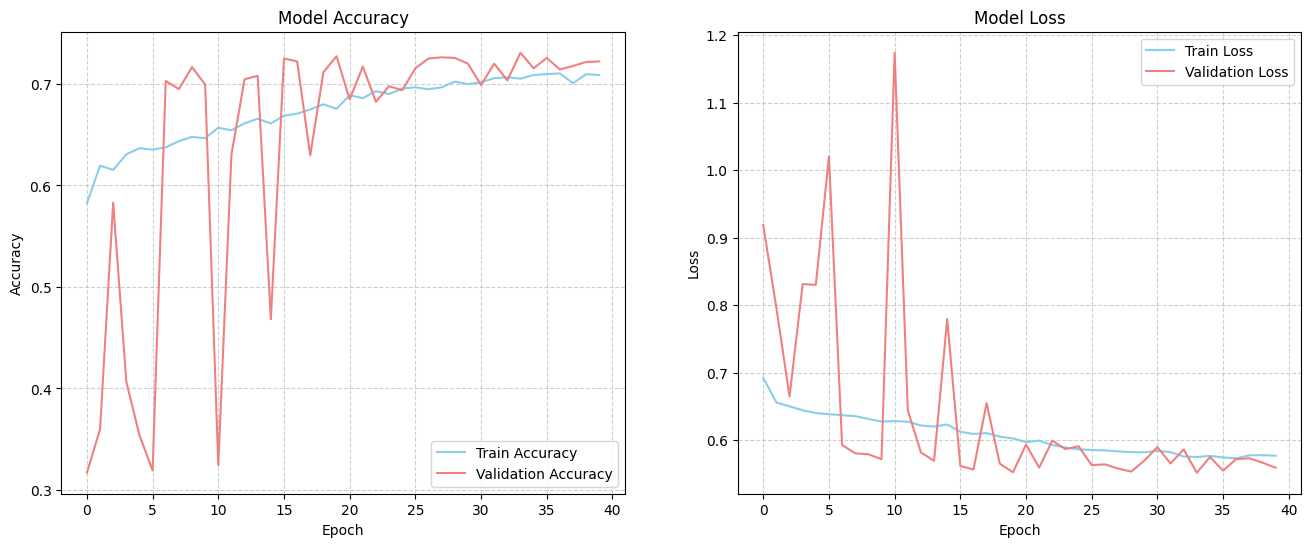

In [10]:
# Plotting training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
ax1.plot(history.history['accuracy'], color='skyblue', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], color='lightcoral', label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Loss
ax2.plot(history.history['loss'], color='skyblue', label='Train Loss')
ax2.plot(history.history['val_loss'], color='lightcoral', label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.show()

## 11: Evaluating the Model

56/56 [==============================] - 3s 45ms/step - loss: 0.5651 - accuracy: 0.7206 - auc: 0.7540 - precision: 0.8148 - recall: 0.7649

--- Final Performance Metrics ---
      Metric     Score
0       Loss  0.565118
1   Accuracy  0.720588
2        AUC  0.754049
3  Precision  0.814815
4     Recall  0.764901
56/56 [==============================] - 3s 42ms/step

--- Classification Report ---
              precision    recall  f1-score   support

     Healthy       0.55      0.62      0.59       560
   Pneumonia       0.81      0.76      0.79      1208

    accuracy                           0.72      1768
   macro avg       0.68      0.69      0.69      1768
weighted avg       0.73      0.72      0.72      1768



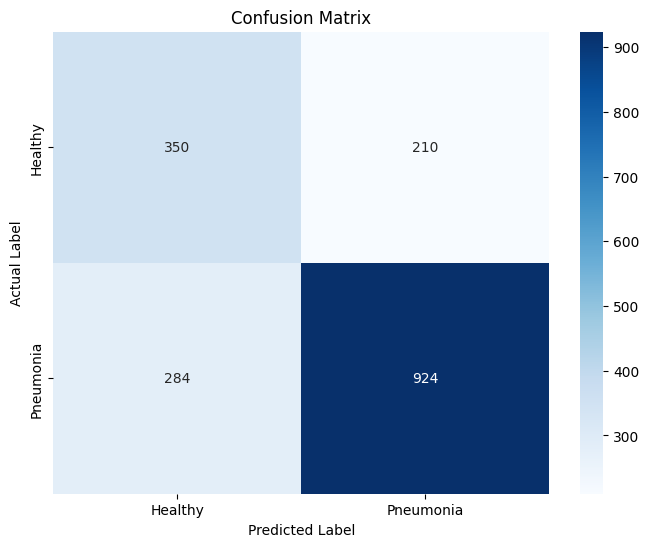

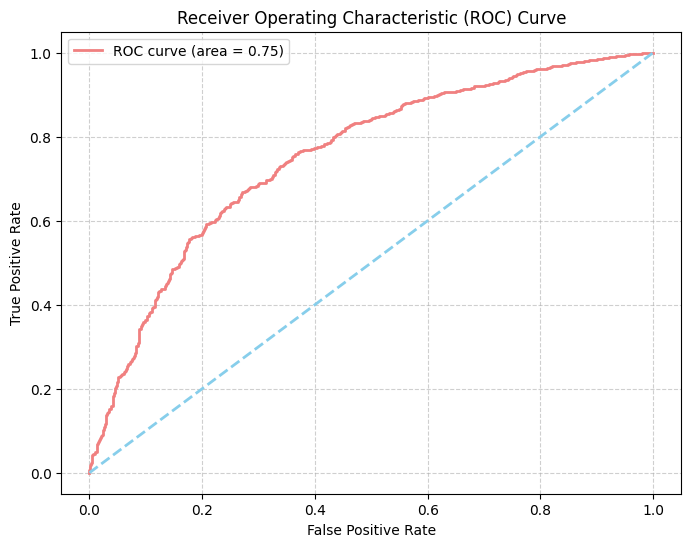

In [11]:
# Evaluating the model on the validation data
results = model.evaluate(validation_generator, verbose=1)

metrics_df = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall'],
    'Score': results
})
print("\n--- Final Performance Metrics ---")
print(metrics_df)


# 
Y_pred = model.predict(validation_generator)
# Turn probabilities (like 0.8) into certain answers (0 or 1)
y_pred = (Y_pred > 0.5).astype(int) 
y_true = validation_generator.classes

# A detailed report with precision, recall, f1-score
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Pneumonia']))

# A confusion matrix to see exactly where the model is getting confused.
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Pneumonia'], yticklabels=['Healthy', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# The ROC curve, a good way to see the overall performance of the classifier.
fpr, tpr, thresholds = roc_curve(y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightcoral', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 12: Saving the Final Model

In [12]:
model.save('../models/custom_cnn_baseline_final.h5')
print("Model saved.")

Model saved.
